<a href="https://colab.research.google.com/github/yogaliu-ds/Bert_sentiment_analysis/blob/main/Adding_new_layers_to_Bert_pytorch_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Import modules

In [1]:
pip install datasets transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.1 MB/s 
     |████████████████████████████████| 4.9 MB 58.8 MB/s 
     |████████████████████████████████| 212 kB 70.7 MB/s 
     |████████████████████████████████| 120 kB 70.8 MB/s 
     |████████████████████████████████| 115 kB 71.3 MB/s 
     |████████████████████████████████| 127 kB 72.5 MB/s 
     |████████████████████████████████| 6.6 MB 50.8 MB/s 
     |████████████████████████████████| 1.3 MB 63.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from transformers import BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoConfig
from torch.utils.data import TensorDataset, Dataset, DataLoader

from collections import defaultdict


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

# 1.Data preprocessing

In [3]:
# Import data and train_val_test_split
df = pd.read_csv('/content/drive/MyDrive/Research/Finbert/labeled_sentiment_data.csv')

# Categorical to numerical (Because we want it to be transformed into tensor)
df['Sentiment'] = df['Sentiment'].replace('negative', 0)
df['Sentiment'] = df['Sentiment'].replace('neutral', 1)
df['Sentiment'] = df['Sentiment'].replace('positive', 2)

random_seed = 0

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=random_seed)

print(df_train.shape, df_val.shape, df_test.shape)

# print(X_train.size, X_val.size, X_test.size)

df

(4673, 2) (584, 2) (585, 2)


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1
...,...,...
5837,RISING costs have forced packaging producer Hu...,0
5838,Nordic Walking was first used as a summer trai...,1
5839,"According shipping company Viking Line , the E...",1
5840,"In the building and home improvement trade , s...",1


In [4]:
# Define the tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# Check the max_len
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df['Sentence'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len = max(token_lens)
print(max_len)

150


Text(0.5, 6.79999999999999, 'Token count')

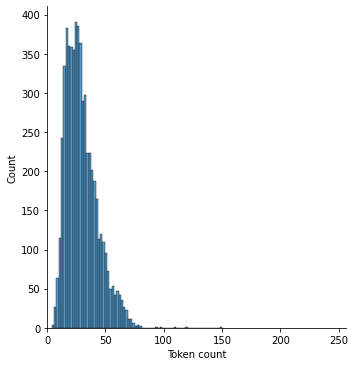

In [6]:
# plot the distribution of review lengths 
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

# 2.Dataset and Dataloader

In [7]:
# Dataset

class CustomDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        target = self.targets[idx]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# Note: encode only returns input_ids
#       encode_plus returns ’input_ids: ids in the embedding
#                         ‘token_type_ids’:区分两个句子的编码（上句全为0，下句全为1）
#                         ‘attention_mask’:指定对哪些词进行self-Attention操作

In [8]:
# DataLoader containing Dataset

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
        reviews=df['Sentence'].to_numpy(),
        targets=df['Sentiment'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [9]:
# Create train, test and val data loaders
batch_size = 16
train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

In [10]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

# 16 (batchsize) * 150 (max_len)
# So, it's 16 samples.

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


# 3.Model Architecture

In [11]:
bert_model = BertModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        # try use 'bert_model' directly
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [13]:
# Call the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(n_classes = 3).to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# Model summary
print(model)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

# --Parameter adjustment--

In [35]:
# Check bert_model
print(bert_model.config)
print('Number of hidden units:', bert_model.config.hidden_size)


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Number of hidden units: 768


In [36]:
# Check model = SentimentClassifier(n_classes = 3).to(device)
params = model.state_dict()
for _ in params.keys():
  print(_)


bert.embeddings.position_ids
bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attenti

In [37]:
keys = list(params.keys())
keys

['bert.embeddings.position_ids',
 'bert.embeddings.word_embeddings.weight',
 'bert.embeddings.position_embeddings.weight',
 'bert.embeddings.token_type_embeddings.weight',
 'bert.embeddings.LayerNorm.weight',
 'bert.embeddings.LayerNorm.bias',
 'bert.encoder.layer.0.attention.self.query.weight',
 'bert.encoder.layer.0.attention.self.query.bias',
 'bert.encoder.layer.0.attention.self.key.weight',
 'bert.encoder.layer.0.attention.self.key.bias',
 'bert.encoder.layer.0.attention.self.value.weight',
 'bert.encoder.layer.0.attention.self.value.bias',
 'bert.encoder.layer.0.attention.output.dense.weight',
 'bert.encoder.layer.0.attention.output.dense.bias',
 'bert.encoder.layer.0.attention.output.LayerNorm.weight',
 'bert.encoder.layer.0.attention.output.LayerNorm.bias',
 'bert.encoder.layer.0.intermediate.dense.weight',
 'bert.encoder.layer.0.intermediate.dense.bias',
 'bert.encoder.layer.0.output.dense.weight',
 'bert.encoder.layer.0.output.dense.bias',
 'bert.encoder.layer.0.output.LayerN

In [38]:
# Turn off requiires_grad of some parameters
i=0
for param in model.parameters():
  i+=1
  if i <50:
    param.requires_grad = False

In [39]:
# (Check) If we set thme to False successfully

for param in model.parameters():
  print(param.requires_grad == True)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
T

# 4.Fine-Tuning Setting

In [40]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [41]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

# 5.Fine-tuning


In [43]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.2582714701852715 accuracy 0.8788786646693773
Val   loss 0.6560865823601095 accuracy 0.7808219178082192

Epoch 2/10
----------
Train loss 0.19430887497029403 accuracy 0.8932163492403167
Val   loss 0.7565012836759608 accuracy 0.7791095890410958

Epoch 3/10
----------
Train loss 0.16980406853216207 accuracy 0.8981382409586989
Val   loss 0.8462212405331131 accuracy 0.7756849315068493

Epoch 4/10
----------
Train loss 0.15556201963318328 accuracy 0.9030601326770811
Val   loss 0.8946497967841129 accuracy 0.7756849315068493

Epoch 5/10
----------
Train loss 0.1432949108375676 accuracy 0.9169698266638134
Val   loss 0.9788146017676194 accuracy 0.7756849315068493

Epoch 6/10
----------
Train loss 0.14139637825614754 accuracy 0.9158998502032956
Val   loss 1.078677784111917 accuracy 0.7517123287671232

Epoch 7/10
----------
Train loss 0.13703837727793292 accuracy 0.921677723090092
Val   loss 1.1711609565111734 accuracy 0.761986301369863

Epoch 8/10
----------
Tra

In [44]:
torch.tensor(history['train_acc'], device='cpu')

tensor([0.8789, 0.8932, 0.8981, 0.9031, 0.9170, 0.9159, 0.9217, 0.9180, 0.9185,
        0.9180], dtype=torch.float64)

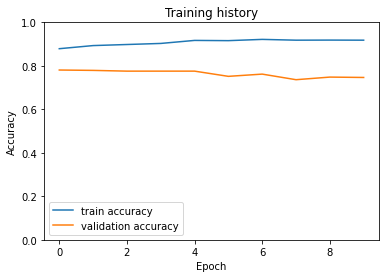

In [45]:
# Plot training and validation accuracy

plt.plot(torch.tensor(history['train_acc'], device='cpu'), label='train accuracy')
plt.plot(torch.tensor(history['val_acc'], device='cpu'), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [46]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7760683760683761

# 6.Model Evaluation

In [47]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [48]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [49]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.47      0.32      0.38        92
     neutral       0.82      0.86      0.84       338
    positive       0.80      0.88      0.84       155

    accuracy                           0.78       585
   macro avg       0.70      0.68      0.68       585
weighted avg       0.76      0.78      0.76       585



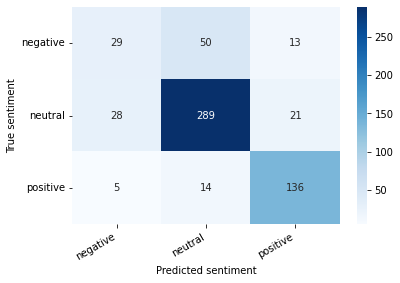

In [50]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)



# 7.Prediction of raw text

In [51]:
review_text = "I'm starving."


In [52]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=max_len,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
)


In [53]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: I'm starving.
Sentiment  : neutral


# 新增區段